## Module Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV,train_test_split
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

## Loading and Cleaning Data

In [2]:
def load_arff(file_path):
    data = []
    attributes = []
    reading_data = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            # Skip comments and empty lines
            if line.startswith('%') or line == '':
                continue

            # Read attribute names
            if line.lower().startswith('@attribute'):
                attr_name = line.split()[1]
                attributes.append(attr_name)

            # Start reading data when @data is encountered
            if line.lower() == '@data':
                reading_data = True
                continue

            # Read data rows
            if reading_data:
                data.append(line.split(','))

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=attributes)
    
    return df

In [3]:
def clean_data(df):
    # Remove quotes from column names
    df.columns = df.columns.str.replace("'", "").str.strip()

    # Remove quotes from string values
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.replace("'", "").str.strip()

    return df

In [4]:
# Load the file
train_df = clean_data(load_arff('data/KDDTrain+.arff'))
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [5]:
test_df = clean_data(load_arff('data\KDDTest+.arff'))
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.00,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71,anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal
22540,0,tcp,http,SF,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,anomaly
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
df = pd.concat([train_df,test_df],ignore_index=True)

In [7]:
df.dtypes

duration                       object
protocol_type                  object
service                        object
flag                           object
src_bytes                      object
dst_bytes                      object
land                           object
wrong_fragment                 object
urgent                         object
hot                            object
num_failed_logins              object
logged_in                      object
num_compromised                object
root_shell                     object
su_attempted                   object
num_root                       object
num_file_creations             object
num_shells                     object
num_access_files               object
num_outbound_cmds              object
is_host_login                  object
is_guest_login                 object
count                          object
srv_count                      object
serror_rate                    object
srv_serror_rate                object
rerror_rate 

In [8]:
# Convert possible numeric columns to proper datatypes
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass  # Ignore if conversion fails (means it's categorical)


## Exploratory Data Analysis

### Basic Information

In [9]:
df.shape[0]

148517

In [10]:
df.duplicated().sum()

629

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

### Class Distribution

In [13]:
df.value_counts('class')

class
normal     76967
anomaly    70921
dtype: int64

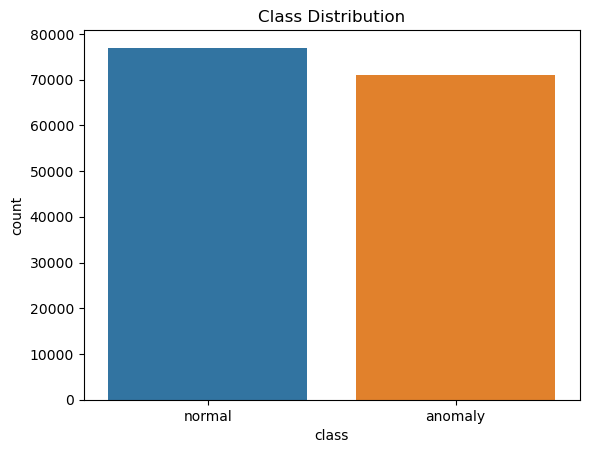

In [14]:
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

### Protocol Type Distribution

In [15]:
df['protocol_type'].value_counts()

tcp     121351
udp      17541
icmp      8996
Name: protocol_type, dtype: int64

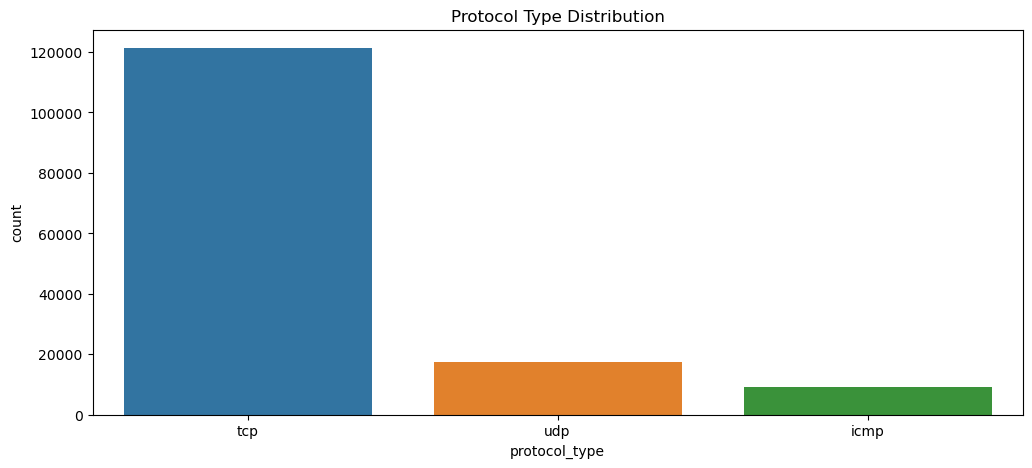

In [16]:
plt.figure(figsize=(12, 5))
sns.countplot(x='protocol_type', data=df, order=df['protocol_type'].value_counts().index)
plt.title('Protocol Type Distribution')
plt.show()


### Top 10 services used

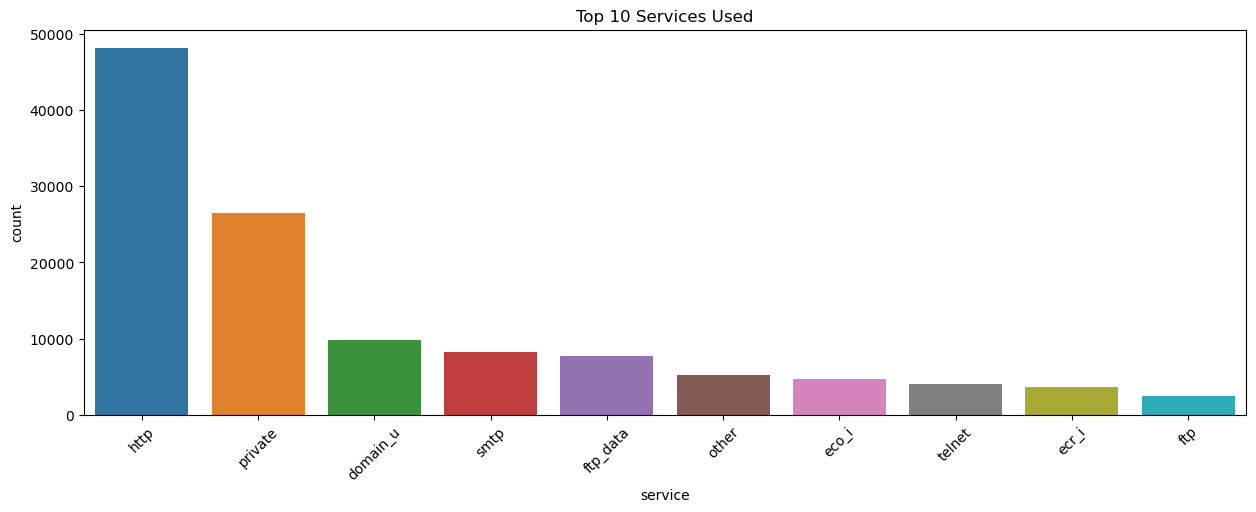

In [17]:
plt.figure(figsize=(15, 5))
sns.countplot(x='service', data=df, order=df['service'].value_counts().head(10).index)
plt.title('Top 10 Services Used')
plt.xticks(rotation=45)
plt.show()

### Total Types of Flags and their Distribution

In [18]:
df['flag'].value_counts()

SF        89385
S0        36808
REJ       14960
RSTR       3082
RSTO       2329
S1          386
SH          344
S3          298
S2          142
RSTOS0      105
OTH          49
Name: flag, dtype: int64

## Feature Encoding

In [19]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

In [20]:
le(df)

In [21]:
df.drop(['num_outbound_cmds'], axis=1, inplace=True)

## Data Splitting

In [22]:
# Training
X = df.drop('class', axis=1)
y = df[['class']]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

In [24]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

selected_features

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

Index(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count',
       'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate'],
      dtype='object')

In [25]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

## Feature Scaling

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## ML Model Training and Testing

#### Logistic Regression

#### Decision Tree

#### Random Forest

#### K Nearest Classifier

In [27]:
# Dictionary of Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN Classifier': KNeighborsClassifier()
}

In [28]:
params = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [5, 10, 20]},
    'Random Forest': {'n_estimators': [100, 200, 300]},
    'KNN Classifier': {'n_neighbors': [3, 5, 7, 9]}
}

In [29]:
# DataFrame to Store Results
results = []
y_test_res = pd.DataFrame()
y_test_res['Actual'] = y_test.values.ravel()


In [30]:
for name, model in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(model, params[name], cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"{name} Training Complete.")

    # Model predictions
    y_pred = best_model.predict(X_test)
    y_test_res[name] = y_pred

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, precision, recall, f1])


Training Logistic Regression...


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Logistic Regression Training Complete.
Training Decision Tree...
Decision Tree Training Complete.
Training Random Forest...


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

Random Forest Training Complete.
Training KNN Classifier...


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

KNN Classifier Training Complete.


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [31]:
dnn_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

In [32]:
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = dnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9003 - loss: 0.2521 - val_accuracy: 0.9434 - val_loss: 0.1513
Epoch 2/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9335 - loss: 0.1738 - val_accuracy: 0.9491 - val_loss: 0.1358
Epoch 3/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9419 - loss: 0.1576 - val_accuracy: 0.9514 - val_loss: 0.1467
Epoch 4/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9432 - loss: 0.1518 - val_accuracy: 0.9529 - val_loss: 0.1386
Epoch 5/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9454 - loss: 0.1446 - val_accuracy: 0.9561 - val_loss: 0.1147
Epoch 6/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9473 - loss: 0.1349 - val_accuracy: 0.9547 - val_loss: 0.1023
Epoch 7/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9522 - loss: 0.1236 - val_accuracy: 0.9575 - val_loss: 0.1298
Epoch 8/100
2958/2958 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9542 - l

In [33]:
# Model predictions
y_pred = (dnn_model.predict(X_test) > 0.5).astype(int)
y_test_res['Deep Learning'] = y_pred

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results.append(['Deep Learning', acc, precision, recall, f1])

925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## Model Evaluation Results

In [34]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.906214,0.891541,0.931705,0.911181
1,Decision Tree,0.993813,0.995013,0.992994,0.994003
2,Random Forest,0.994895,0.995543,0.994565,0.995054
3,KNN Classifier,0.982656,0.984124,0.982255,0.983189
4,Deep Learning,0.954933,0.942424,0.972106,0.957035


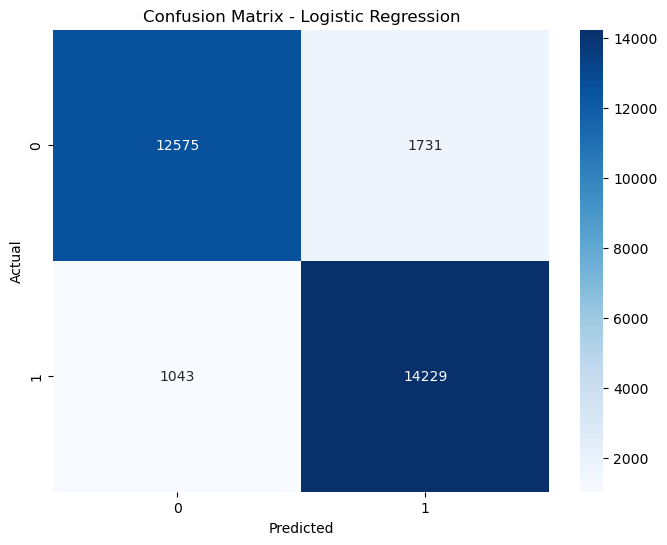

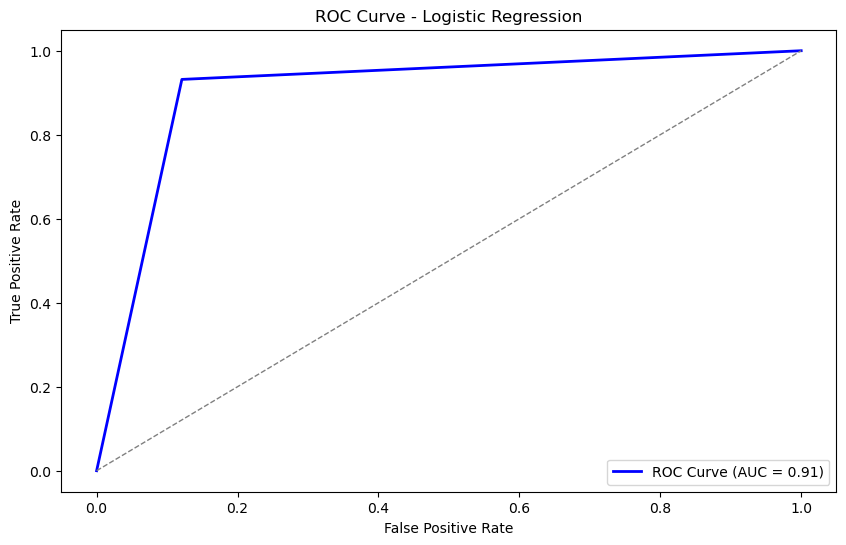

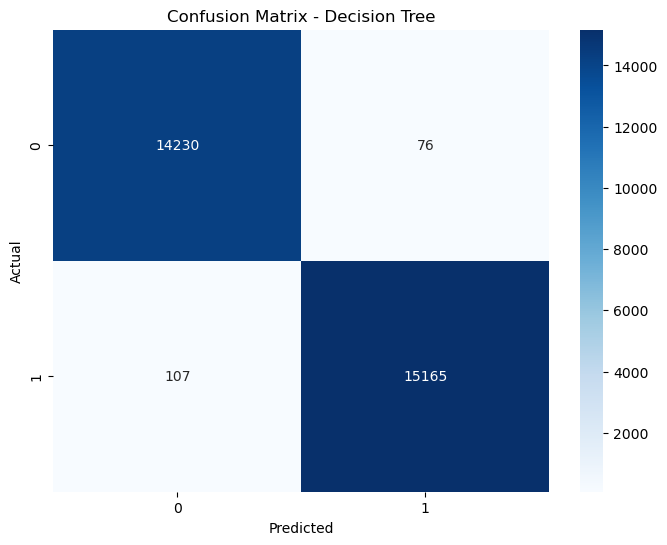

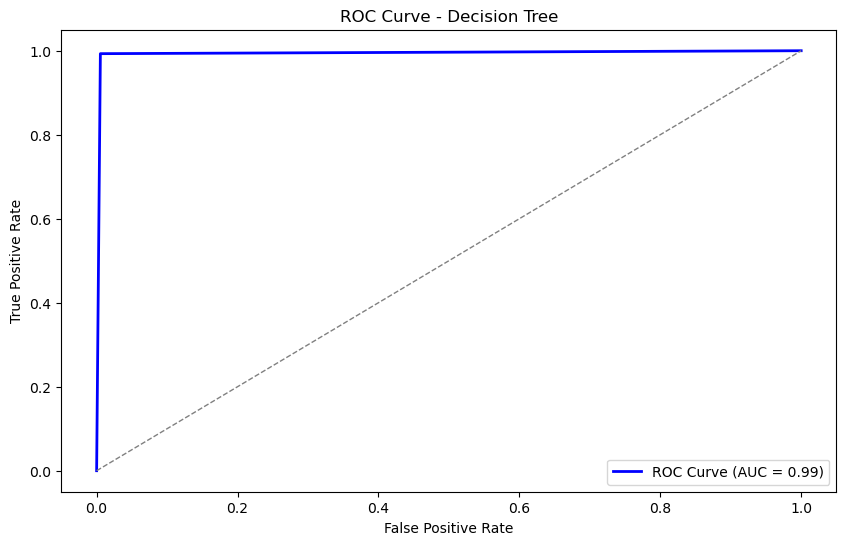

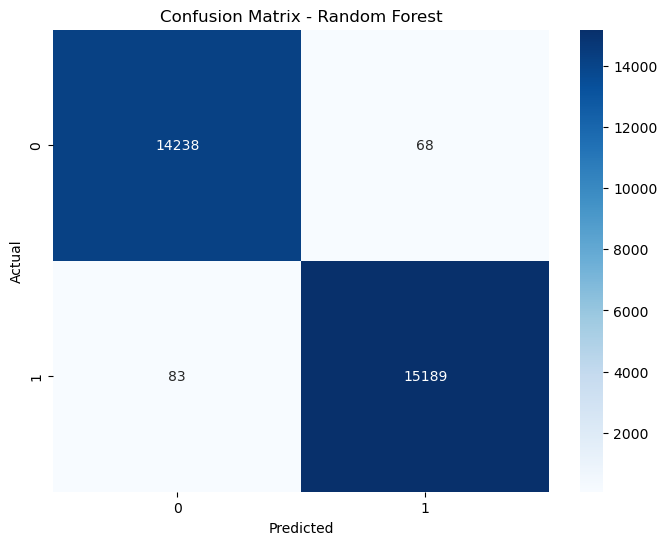

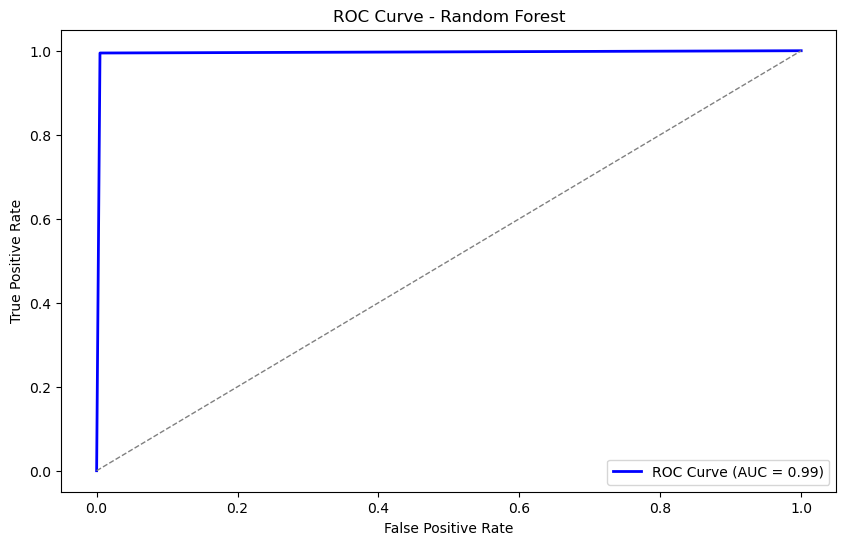

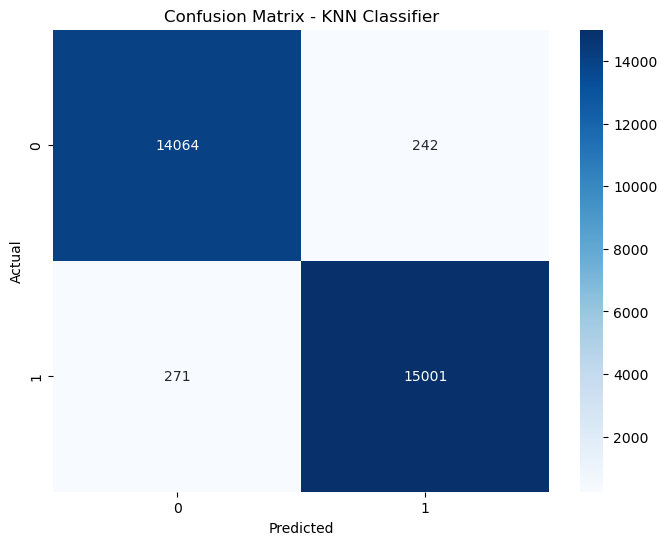

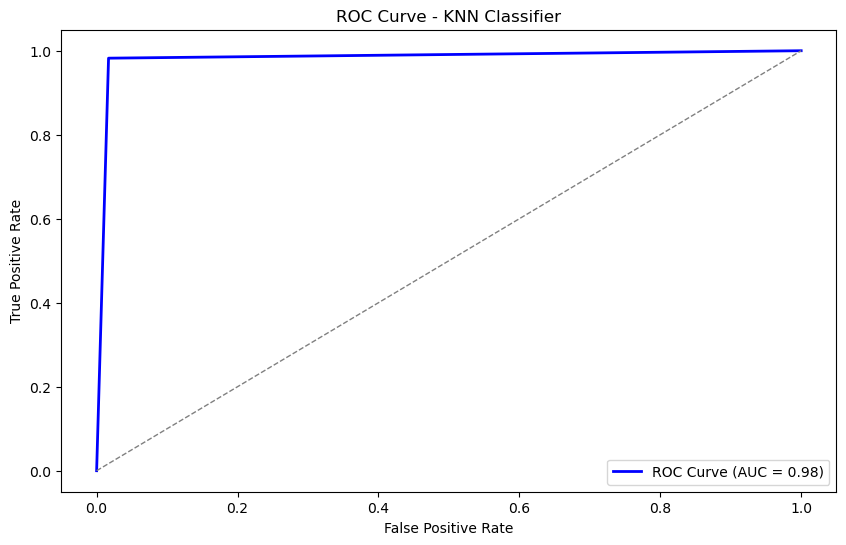

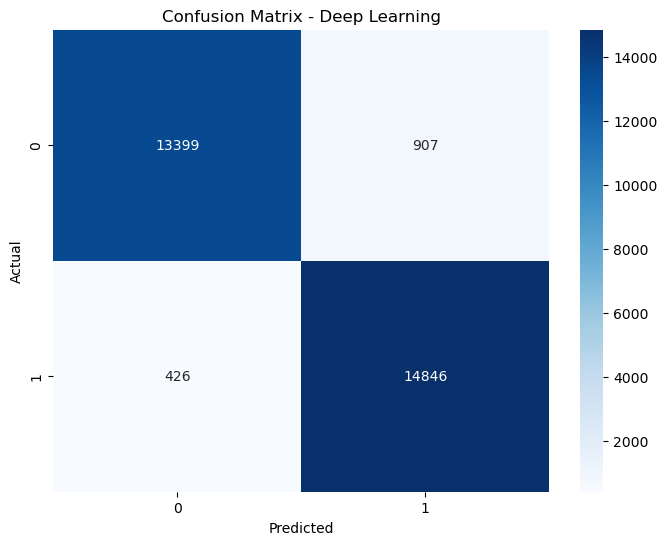

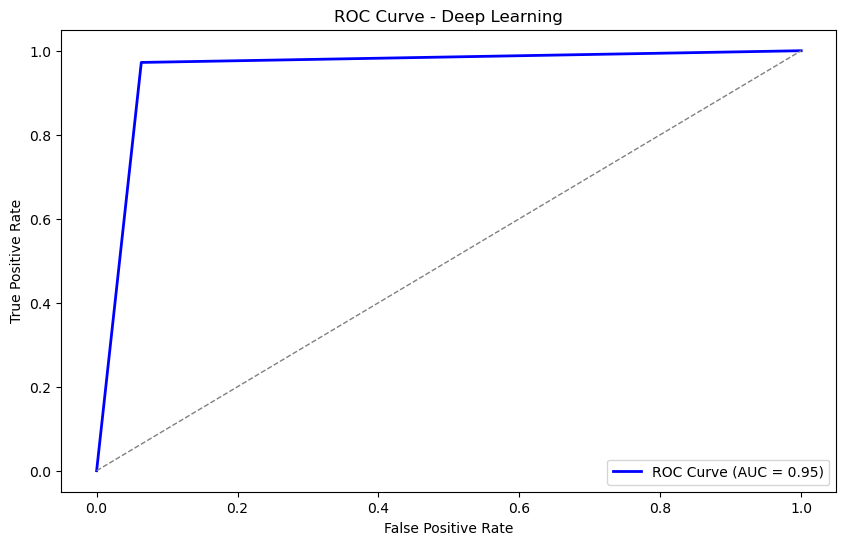

In [35]:
# Plot Heatmap Confusion Matrix for Each Model
for name in y_test_res.columns[1:]:
    cm = confusion_matrix(y_test, y_test_res[name])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_test_res[name])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.title(f'ROC Curve - {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



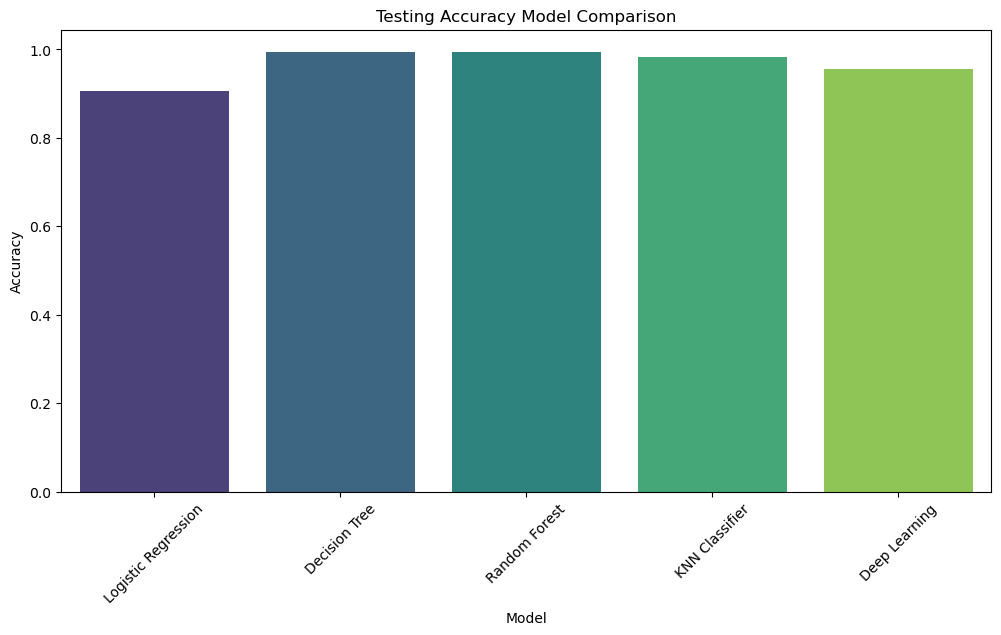

In [36]:
# Model Comparison Graph
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Testing Accuracy Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()
